In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import pathlib

In [7]:
DATA_PATH = pathlib.Path('dataset') / "chest_xray"
TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / 'test'
VAL_PATH = DATA_PATH / 'val'

In [22]:
transform = transforms.Compose([
    transforms.Resize(size=(1000, 1200)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform)

train_dataset, val_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 5216
     Root location: dataset\chest_xray\train
     StandardTransform
 Transform: Compose(
                Resize(size=(1000, 1200), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 16
     Root location: dataset\chest_xray\val
     StandardTransform
 Transform: Compose(
                Resize(size=(1000, 1200), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 624
     Root location: dataset\chest_xray\test
     StandardTransform
 Transform: Compose(
                Resize(size=(1000, 1200), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [26]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
classes = {
    0: "Normal",
    1: "Pneumonia"
          }

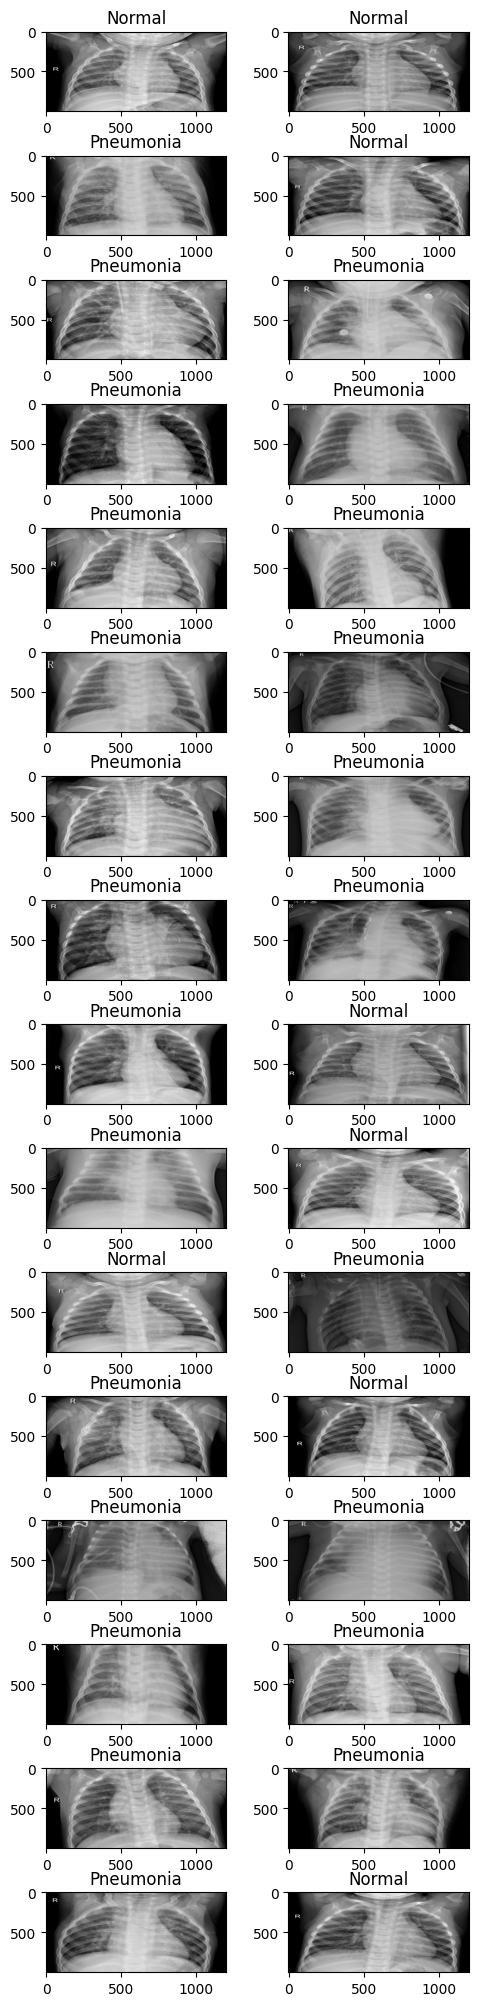

In [40]:
for img, label in train_dataloader:
    fig, ax = plt.subplots(nrows = int(BATCH_SIZE / 2), ncols = 2, figsize=(5, 20))
    fig.tight_layout()
    for i in range(BATCH_SIZE):
        ax[int(i/2), i%2].imshow(img[i].permute(1, 2, 0), aspect='auto')
        ax[int(i/2), i%2].set_title(classes[label[i].item()])
    break